In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)

import pandas as pd
import numpy as np

In [2]:
def pd2r(df):
    # For all columns with dtype = object (i.e. mixed dtypes)
    # Replace all NA's and NaN's with None
    df.loc[:, df.dtypes == object] = df.loc[:, df.dtypes == object].where((pd.notnull(df)), None)
    return df

In [3]:
nba_potw = pd2r(pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv'))

In [4]:
nba_potw_team_agg = nba_potw.groupby(['Team', 'Season short'])[['Date']].count().reset_index().rename(columns = {'Season short': 'Year', 'Date': 'Potw_Count'})
# nba_potw_player_agg = nba_potw.groupby(['Player', 'Team', 'Season short'])[['Date']].count().reset_index().rename(columns = {'Season short': 'Year', 'Date': 'Potw_Count'})

In [5]:
# nba_potw_ct = nba_potw_player_agg.groupby(['Year']).agg({'Potw_Count': 'max'}).reset_index()
# nba_potw_max = pd.merge(nba_potw_ct, nba_potw_player_agg, on = ['Year', 'Potw_Count'], how = 'left')[['Year', 'Team', 'Potw_Count']].assign(isMaxPotw = 'Yes')

In [6]:
nba_summary = pd.read_csv('../data/scraped/NBA_Yearly_Summary.csv')
nba_summary = nba_summary[['Year', 'League Champion']].rename(columns = {'League Champion': 'Team'}).assign(isChampion = 'Yes')

In [7]:
nba_colors = pd.read_csv('../data/scraped/NBA_Teams_Color.csv')

In [8]:
nba_df = pd.merge(nba_potw_team_agg, nba_summary, on = ['Year', 'Team'], how = 'left')
nba_df.isChampion = nba_df.isChampion.where((pd.notnull(nba_df.isChampion)), 'No')

In [9]:
max_potw = nba_df.groupby('Year')[['Potw_Count']].max().reset_index().assign(isMaxPotw = 'Yes')
nba_df_potw = pd.merge(nba_df, max_potw, on = ['Year', 'Potw_Count'], how = 'left')
nba_df_potw.isMaxPotw = nba_df_potw.isMaxPotw.where((pd.notnull(nba_df_potw.isMaxPotw)), 'No')

In [10]:
nba_color_missing = pd.merge(nba_df, nba_colors, left_on = 'Team', right_on = 'Franchise', how = 'left')
list(nba_color_missing.loc[nba_color_missing.Color1.isna()]['Team'].unique())

['Charlotte Bobcats',
 'New Jersey Nets',
 'New Orleans Hornets',
 'Philadelphia Sixers',
 'Washington Bullets']

In [11]:
missing_teams = {'Charlotte Bobcats': 'Charlotte Hornets', 'New Jersey Nets': 'Brooklyn Nets', 'New Orleans Hornets': 'New Orleans Pelicans', 'Philadelphia Sixers': 'Philadelphia 76ers', 'Washington Bullets': 'Washington Wizards'}
nba_df['Team'] = nba_df['Team'].replace(missing_teams)

In [12]:
nba_colors = nba_colors.set_index('Franchise')
nba_ggplot_fill = nba_colors['Color1']
nba_ggplot_color = nba_colors['Color2']

In [13]:
nba_champ = nba_df_potw.loc[nba_df_potw.isChampion == 'Yes']
nba_nonchamp_maxpotw = nba_df_potw.loc[(nba_df_potw.isChampion == 'No') & (nba_df_potw.isMaxPotw == 'Yes')]
nba_nonchamp_nonmaxpotw = nba_df_potw.loc[(nba_df_potw.isChampion == 'No') & (nba_df_potw.isMaxPotw == 'No')]

In [14]:
%R -i nba_champ
%R -i nba_nonchamp_maxpotw
%R -i nba_nonchamp_nonmaxpotw
%R -i nba_ggplot_color
%R -i nba_ggplot_fill

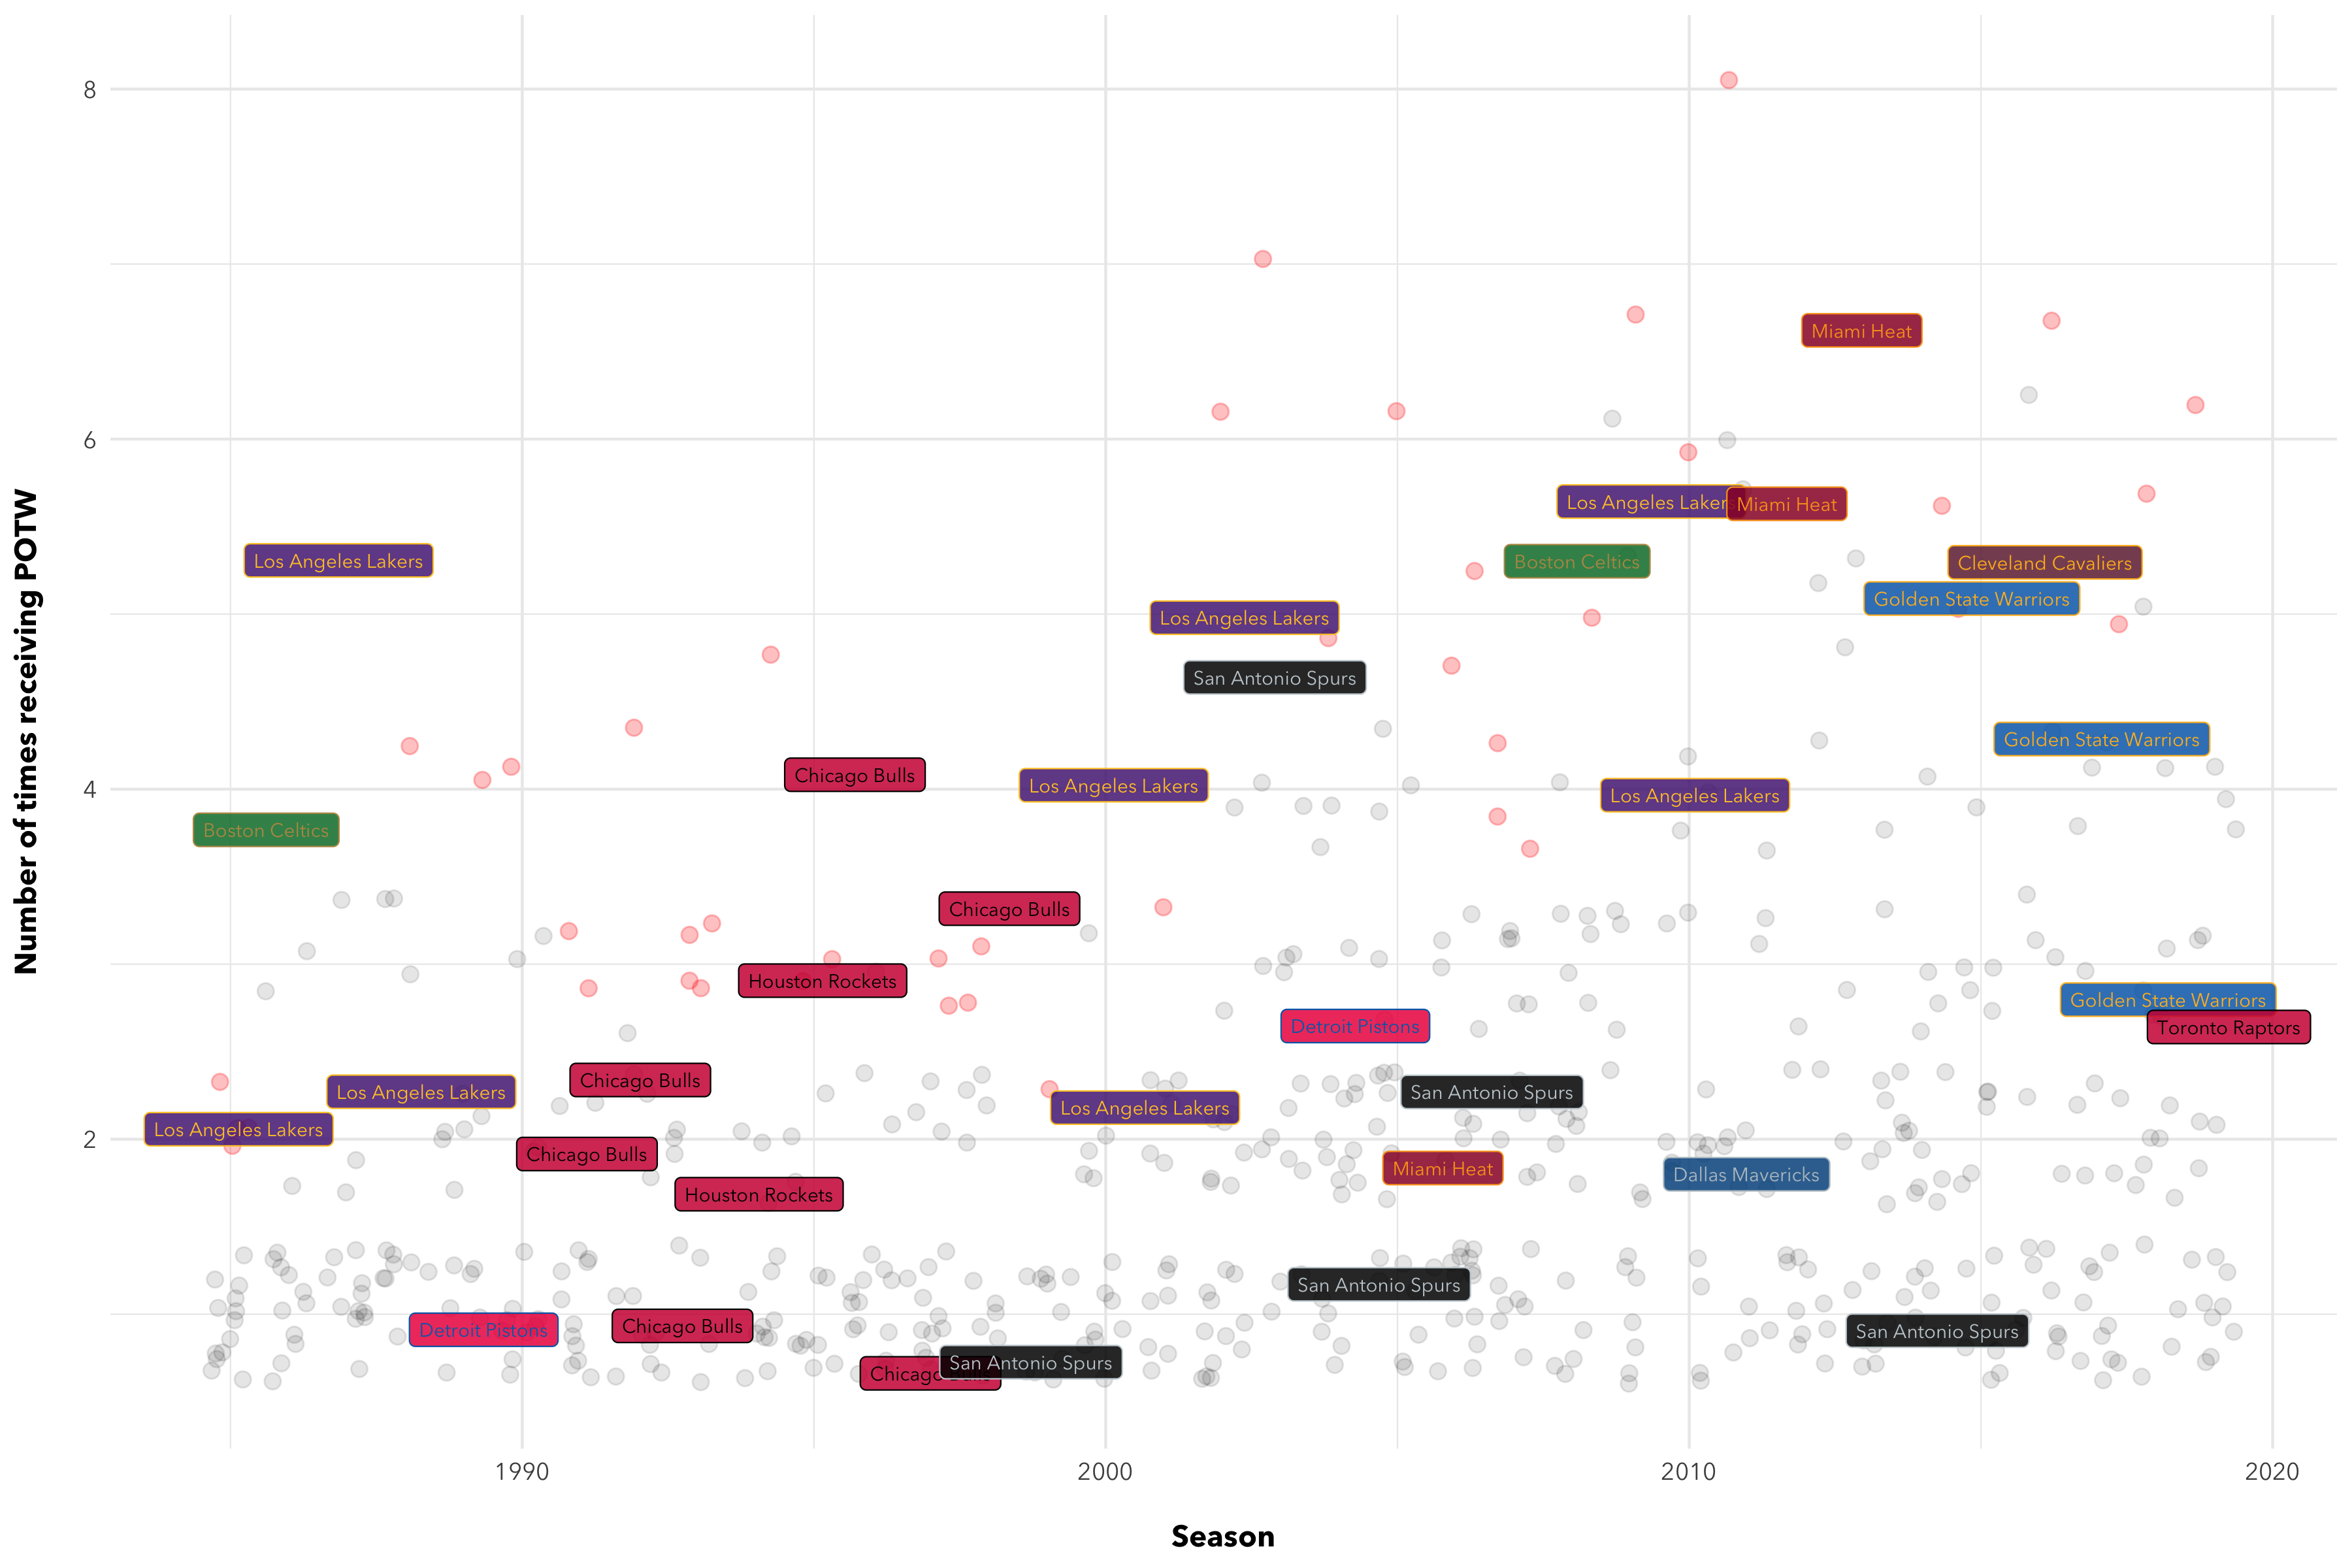

In [15]:
%%R -w 12 -h 8 --units in -r 300
ggplot() +
geom_point(aes(x = Year, y = Potw_Count),
           data = nba_nonchamp_nonmaxpotw, position = 'jitter', alpha = 0.1, size = 2.5) +
geom_point(aes(x = Year, y = Potw_Count),
           data = nba_nonchamp_maxpotw, position = 'jitter', alpha = 0.25, size = 2.5, color = 'red') +
geom_label(aes(x = Year, y = Potw_Count, color = Team, fill = Team, label = Team),
           data = nba_champ, position = 'jitter', size = 2.5, alpha = 0.85, family = 'Avenir Next') +
scale_color_manual(values = nba_ggplot_color) +
scale_fill_manual(values = nba_ggplot_fill) +
scale_x_continuous(name = '\nSeason') +
scale_y_continuous(name = 'Number of times receiving POTW\n') +
theme_minimal() +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      legend.title = element_text(face = 'bold')) +
guides(fill = F, color = F)